In [259]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

#tf.compat.v1.enable_eager_execution(
 #   config=None, device_policy=None, execution_mode=None
#)

In [210]:
# seed must be equal for both training and validation not to overlap.
BATCH_SIZE = 32
IMG_SIZE = (160, 160)  # resolution
directory = "Dataset/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 647 files belonging to 2 classes.
Using 518 files for training.
Found 647 files belonging to 2 classes.
Using 129 files for validation.


In [191]:
class_names = train_dataset.class_names
class_names

['benign', 'malignant']

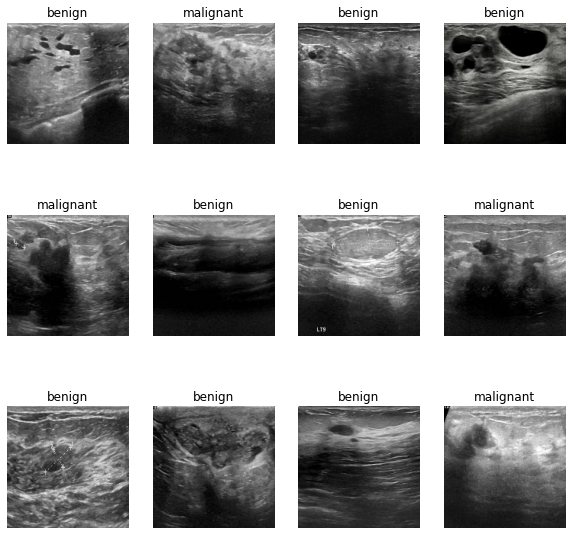

In [173]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [211]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# prevents a memory bottleneck that can occur when reading from disk

In [175]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

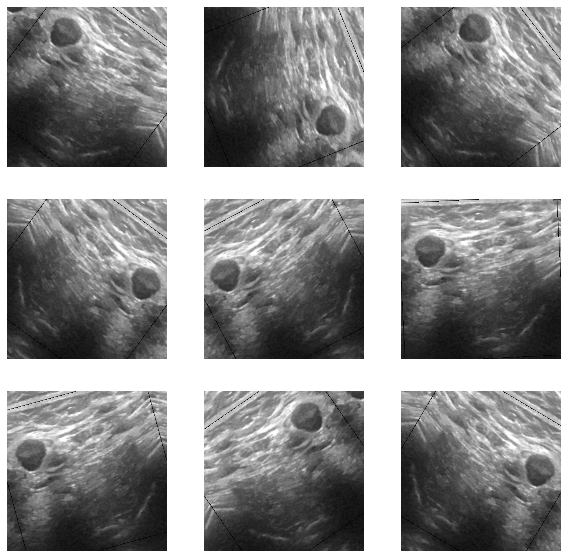

In [176]:
#preview first image augmentations
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/ 255)  # 0-1 float or 0-255 integer values
        plt.axis('off')

In [212]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input #data preprocessing using the same weights the model was trained on

In [213]:
# MobileNet V2 trained on imagenet data
IMG_SHAPE = IMG_SIZE + (3,) # as Img size 160*160 only but we need it 160*160*3 for the model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [214]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_40[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [215]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)  # Last Layer name
# Last two layers are called top layers (Classification)

global_average_pooling2d_20
predictions


In [182]:
# iterate over first batch (32 image) in trainset 
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(32, 1000)


In [183]:
label_batch  # actual labels for those 32 image in first batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0])>

In [216]:
# Create the breast cancer model
def BC_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for multi-class classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # Create the model with its weights without the top layers
     
    base_model.trainable = False  # not to train any of the base model and train only the new layers will be added
    inputs = tf.keras.Input(shape=input_shape)
    
    #x = data_augmentation(inputs) # augmenting the input
    
    x = preprocess_input(inputs) #data preprocessing using the same weights the model was trained on
    
    x = base_model(x, training=False)
    
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.25)(x)
    prediction_layer = tfl.Dense(1) 
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model
    

In [217]:
BCModel = BC_model(IMG_SIZE, data_augmentation)


In [218]:
base_learning_rate = 0.01
BCModel.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [219]:
initial_epochs = 5
history = BCModel.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, use_multiprocessing= True)

Epoch 1/5
17/17 [==============================] - 9s 545ms/step - loss: 0.5877 - accuracy: 0.7664 - val_loss: 0.4995 - val_accuracy: 0.7752
Epoch 2/5
17/17 [==============================] - 8s 495ms/step - loss: 0.3732 - accuracy: 0.8436 - val_loss: 0.5092 - val_accuracy: 0.7984
Epoch 3/5
17/17 [==============================] - 8s 487ms/step - loss: 0.2783 - accuracy: 0.8880 - val_loss: 0.6091 - val_accuracy: 0.7597
Epoch 4/5
17/17 [==============================] - 8s 480ms/step - loss: 0.2362 - accuracy: 0.8996 - val_loss: 0.4630 - val_accuracy: 0.8217
Epoch 5/5
17/17 [==============================] - 8s 491ms/step - loss: 0.2068 - accuracy: 0.9208 - val_loss: 0.5866 - val_accuracy: 0.7907


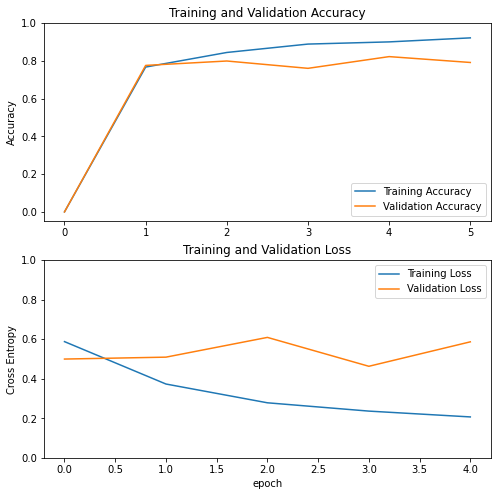

In [220]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [221]:
# Make it trainable from specified layer number
base_model.trainable = True # Make all trainable as a start
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  157


In [222]:
fine_tune_at = 125 # Number to choose

for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

BCModel.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [223]:
BCModel.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_15 (Tens [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_15 (TensorFl [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_21  (None, 1280)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

In [224]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = BCModel.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
17/17 [==============================] - 10s 572ms/step - loss: 0.1996 - accuracy: 0.9073 - val_loss: 0.4122 - val_accuracy: 0.8527
Epoch 6/10
17/17 [==============================] - 8s 476ms/step - loss: 0.1965 - accuracy: 0.9073 - val_loss: 0.3993 - val_accuracy: 0.8450
Epoch 7/10
17/17 [==============================] - 9s 514ms/step - loss: 0.1938 - accuracy: 0.9286 - val_loss: 0.4058 - val_accuracy: 0.8605
Epoch 8/10
17/17 [==============================] - 8s 497ms/step - loss: 0.2036 - accuracy: 0.9247 - val_loss: 0.3976 - val_accuracy: 0.8605
Epoch 9/10
17/17 [==============================] - 9s 536ms/step - loss: 0.1841 - accuracy: 0.9228 - val_loss: 0.3934 - val_accuracy: 0.8605
Epoch 10/10
17/17 [==============================] - 9s 507ms/step - loss: 0.1610 - accuracy: 0.9363 - val_loss: 0.4098 - val_accuracy: 0.8527


In [227]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

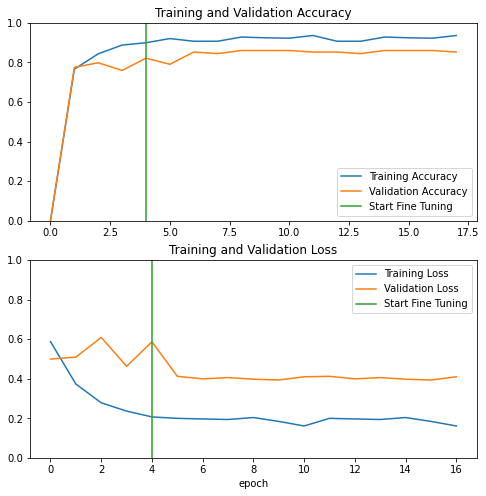

In [228]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [229]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_40[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________